# This notebook is to explore if Ohmnet preserves the relationship of the nodes in the subnetwork like the original network

In [1]:
import sys
sys.path.append("../..")
import platform
import pandas as pd
import numpy as np
import os
import networkx as nx
from src.embedding.network_embedding import *
from src.eda.eda_functions import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances as ed
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

# Prepare data for Ohmnet

In [4]:
subnet1 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\eda_derived\subnetworks_Jan_14\deg_mod=[4],non_deg_mod=[],num_genes=250,min_weight=0.008.csv', index_col = 0)

In [8]:
# convert df from adjacency to edgelist
subnet1.values[tuple([np.arange(len(subnet1))]*2)] = np.nan
subnet1_edge = subnet1.stack().reset_index()

In [9]:
le = LabelEncoder()
le.fit(subnet1.columns)
subnet1_edge.level_0 = le.transform(subnet1_edge.level_0) # convert gene id to number to work with Ohmnet
subnet1_edge.level_1 = le.transform(subnet1_edge.level_1)

LabelEncoder()

In [356]:
subnet1_edge = subnet1_edge[subnet1_edge['level_0'].isin([2627, 2999, 2319])] # take only 3 source genes

In [169]:
subnet1_edge = subnet1_edge[subnet1_edge[0] > 0.012] # and subset with weight > 0.012
subnet1_edge.to_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv', index = 0)

In [2]:
subnet1_edge = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv')

In [ ]:
# Then subnet1_edge is split into 2 dataframes with 12 genes + edges (source and target are the same) overlap 
# The 2 dataframes are then fed to Ohmnet to embed

In [320]:
# edge1 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist1.txt', sep = '\t', header= None)
# edge2 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist2.txt', sep = '\t', header= None)

In [324]:
## check how many nodes overlap betwen these two sub-subnetwork
# len(set(edge1[1]).intersection(edge2[1]))

258

# Embed the original network and see how strong the jaccard is 

In [3]:
subnet1_edge = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv')
subnet1_edge.columns = ['source', 'target', 'weight']

In [5]:
subnet1_G = nx.convert_matrix.from_pandas_edgelist(subnet1_edge, source = 'source', target = 'target',
                                                   edge_attr = 'weight')

In [6]:
subnet1_emb = network_embedding(subnet1_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1')

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


embedding data saved


In [7]:
subnet1_sub1 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist1.txt', sep = '\t', header= None)
subnet1_sub2 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist2.txt', sep = '\t', header= None)
subnet1_sub1.columns = ['source', 'target', 'weight']
subnet1_sub2.columns = ['source', 'target', 'weight']

In [8]:
subnet1_sub1_G = nx.convert_matrix.from_pandas_edgelist(subnet1_sub1, source = 'source', target = 'target',
                                                        edge_attr = 'weight')
subnet1_sub2_G = nx.convert_matrix.from_pandas_edgelist(subnet1_sub2, source = 'source', target = 'target',
                                                        edge_attr = 'weight')

In [9]:
subnet1_sub1_emb = network_embedding(subnet1_sub1_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1_sub1')
subnet1_sub2_emb = network_embedding(subnet1_sub2_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1_sub2')

Computing transition probabilities:  18%|███████▋                                    | 74/421 [00:00<00:00, 732.74it/s]

embedding data saved


Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


embedding data saved


## Compare closest genes for each embedding to the original network by jaccard

In [4]:
def get_closest_genes_jaccard(network, emb, top_n, title):
    ed_data = ed(emb, emb)
    ed_df = pd.DataFrame(ed_data, index = emb.index, columns = emb.index)
    closest_genes1 = [] # find closest genes in the subnetwork
    closest_genes2 = [] # find closest genes in the embedding
    for gene in network.source.unique():
        closest_genes1.append(network[network.source == gene].sort_values('weight', ascending = False)['target'][:top_n])
        top_n_genes = ed_df[gene].sort_values()[1:top_n+1].index
        closest_genes2.append(top_n_genes)
    jac_list = []
    for i in range(len(closest_genes1)):
        jac_list.append(jaccard_similarity(closest_genes1[i], closest_genes2[i]))
#     xticks = le.inverse_transform(subnet1_edge.source.unique())
    plt.rcParams.update({'font.size':18})
    plt.bar(network.source.unique().astype(str), jac_list)
    plt.ylim(0, 1)
    plt.ylabel('Jaccard similarity')
    plt.xlabel('gene')
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(title)
    plt.show()
    plt.close()

In [5]:
subnet1_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1.csv', index_col = 0)
subnet1_sub1_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1_sub1.csv', index_col = 0)
subnet1_sub2_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1_sub2.csv', index_col = 0)

In [6]:
# ohmnet output (embedding)
ohmnet_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\tmp\internal_vectors.emb', sep = ' ', skiprows=1, header = None, index_col = 0)

In [7]:
ohmnet_index = list(ohmnet_emb.index)
new_index = list(map(lambda x:int(x.split('__')[1]), ohmnet_index))
ohmnet_emb.index = new_index

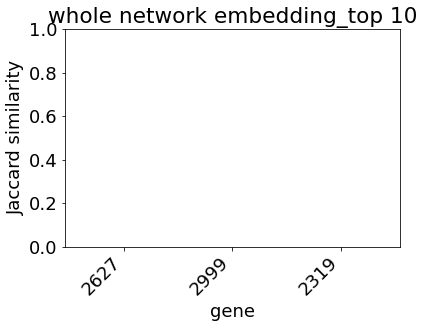

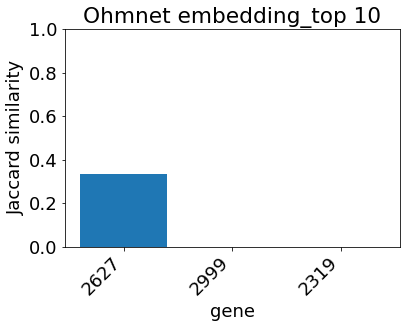

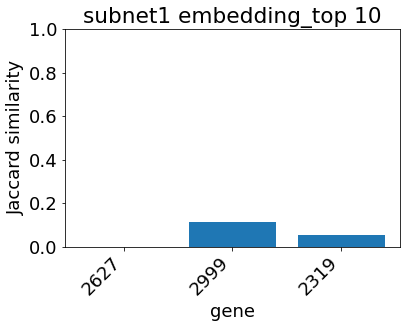

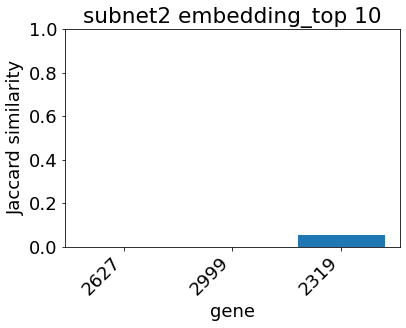

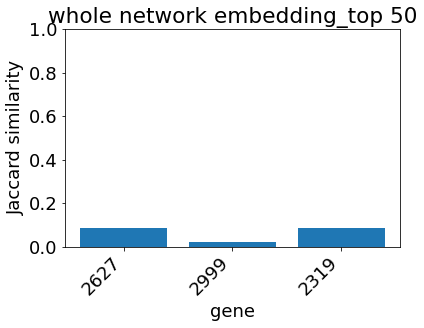

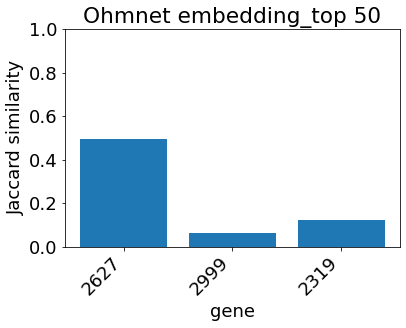

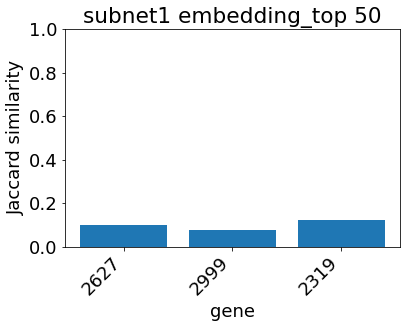

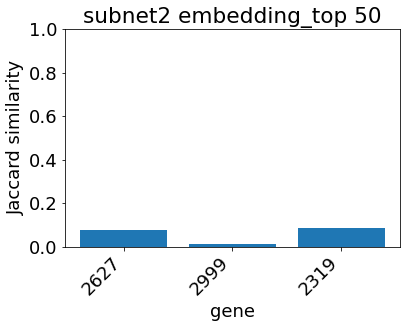

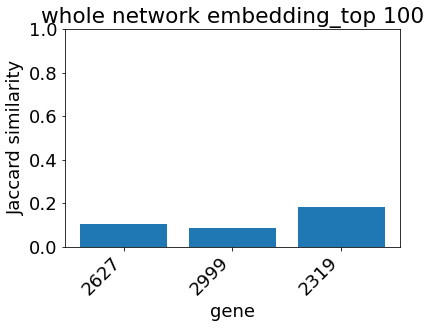

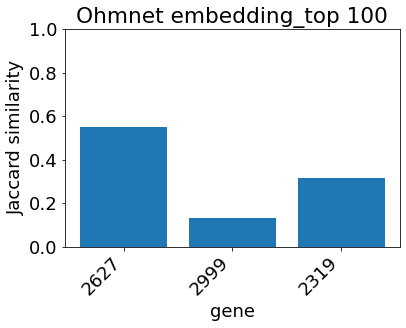

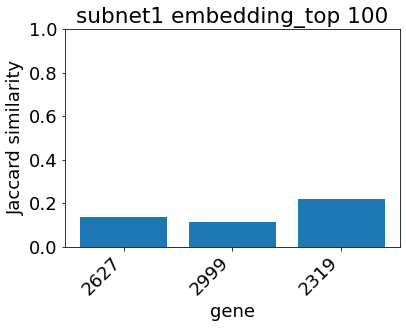

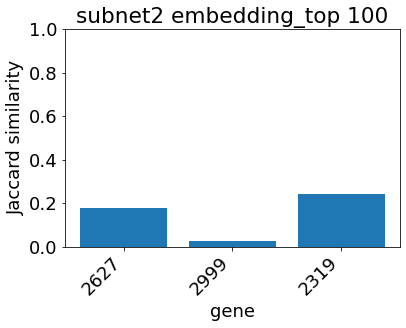

In [10]:
emb_list = [subnet1_emb, ohmnet_emb, subnet1_sub1_emb, subnet1_sub2_emb]
emb_names = ['whole network embedding', 'Ohmnet embedding', 'subnet1 embedding', 'subnet2 embedding']
for n in [10, 50, 100]:
    for i in range(len(emb_list)):
        get_closest_genes_jaccard(subnet1_edge, emb_list[i], n, f'{emb_names[i]}_top {n}')

## Compare between different walks

In [8]:
subnet1_emb_100 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk100_subnet1.csv', index_col = 0)
subnet1_sub1_emb_100 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk100_subnet1_sub1.csv', index_col = 0)
subnet1_sub2_emb_100 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk100_subnet1_sub2.csv', index_col = 0)

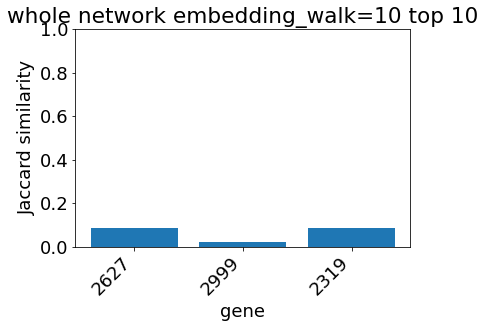

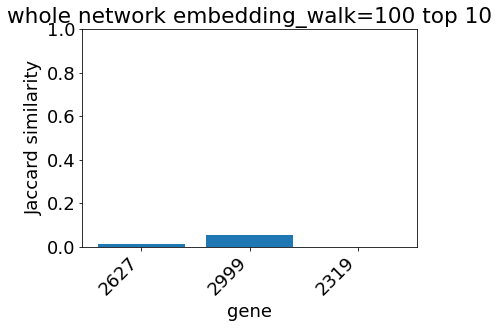

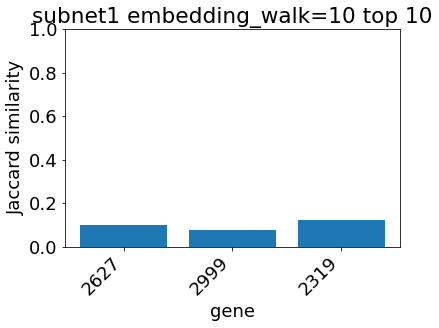

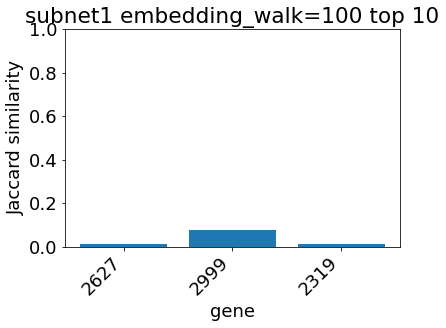

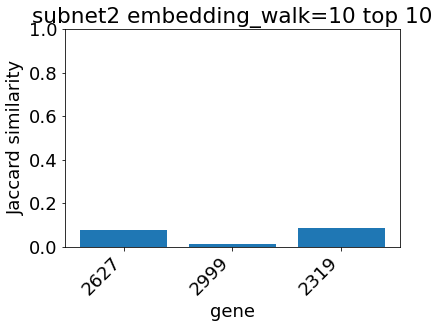

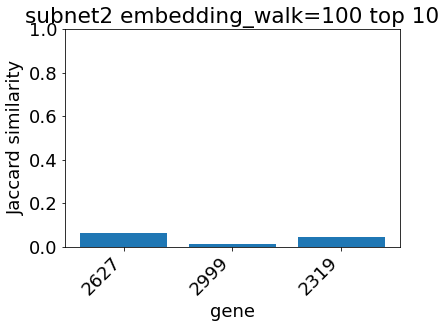

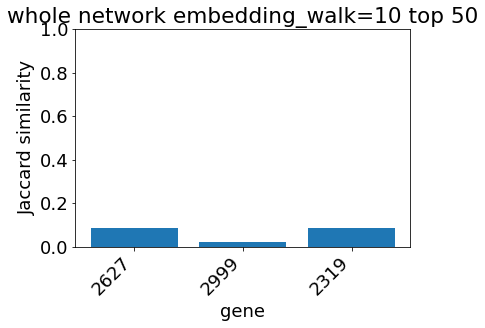

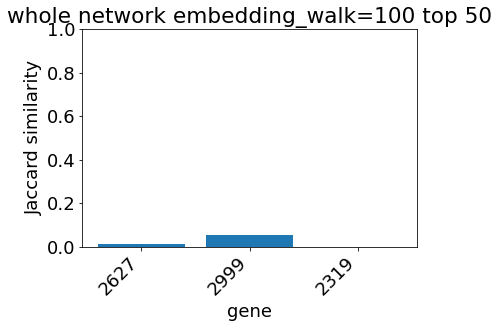

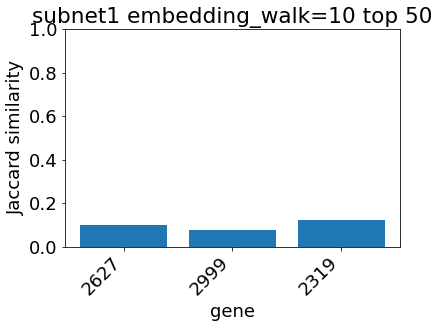

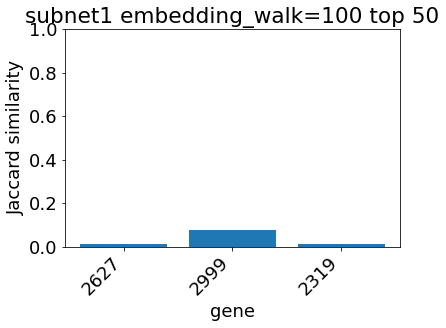

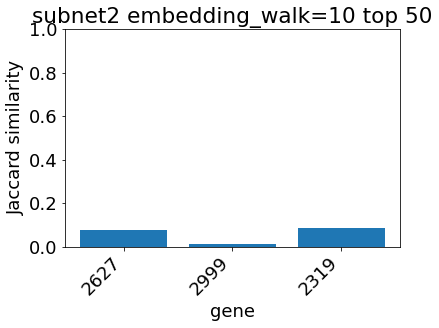

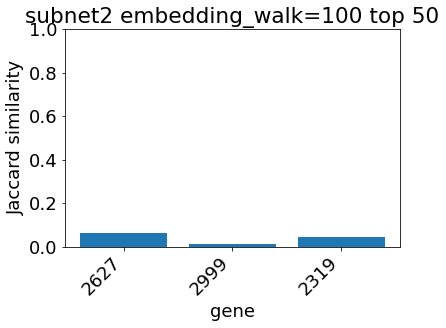

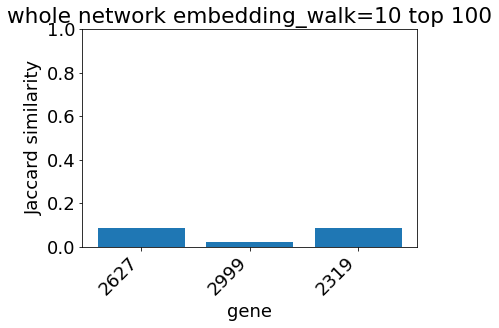

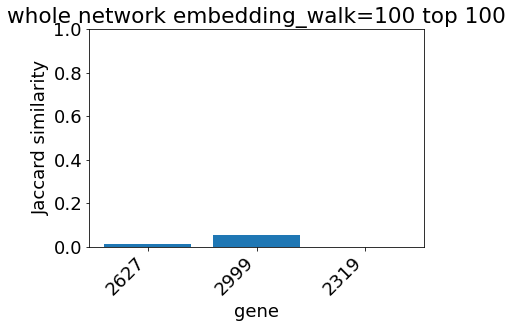

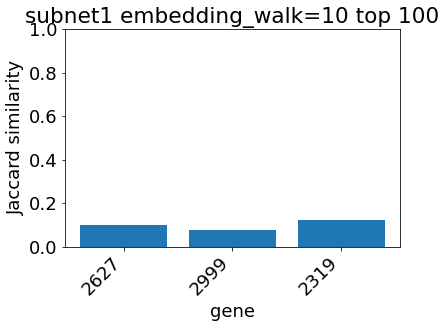

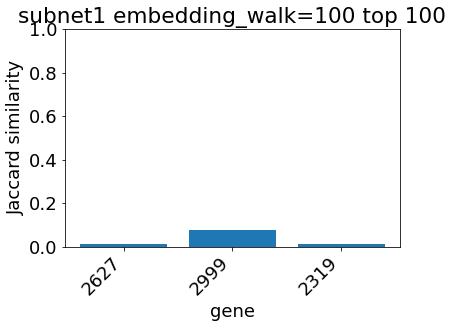

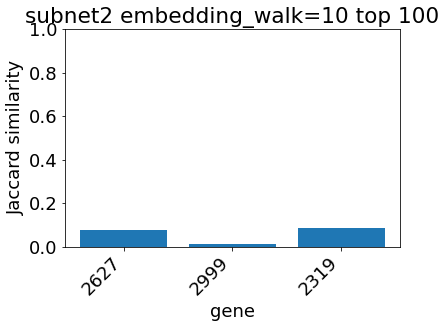

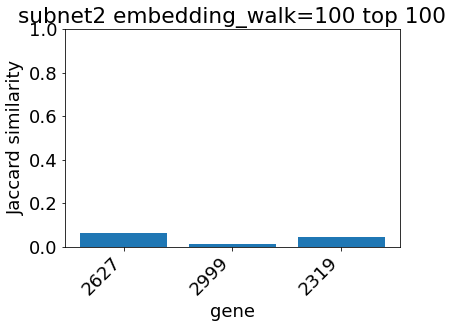

In [17]:
emb_list1 = [subnet1_emb, subnet1_sub1_emb, subnet1_sub2_emb]
emb_list2 = [subnet1_emb_100, subnet1_sub1_emb_100, subnet1_sub2_emb_100]
emb_names = ['whole network embedding', 'subnet1 embedding', 'subnet2 embedding']
n_list = [10, 50, 100]
for n in n_list:
    for i in range(3):
        get_closest_genes_jaccard(subnet1_edge, emb_list1[i], 50, f'{emb_names[i]}_walk=10 top {n}')
        get_closest_genes_jaccard(subnet1_edge, emb_list2[i], 50, f'{emb_names[i]}_walk=100 top {n}')

# Take top 100 DEGs and make a network: problem is 100 genes is still a pretty small network and subset of that is even smaller --> no overlap at all for jaccard

In [152]:
# de_data = pd.read_csv('G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')
# expression = pd.read_csv('G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/PFC_HDID_norm_exp.txt', sep = '\t')
# de_data = pd.read_csv('G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')
# de_data['abs_log2FC'] = abs(de_data['log2FoldChange'])
top100_DEGs = de_data.sort_values('abs_log2FC', ascending=False)['id'].reset_index(drop = True)[:100]
top100_expression = expression[expression.id.isin(top100_DEGs)].reset_index(drop = True)
top100_expression.to_csv('G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/top100_expression.txt', index = 0, sep = '\t') # export for wgcna

In [156]:
top100_tom = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\top100_tom.csv', index_col = 0)

In [158]:
top100_wgcna = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\top100_wgcna_modules.csv')

In [159]:
top100_wgcna

,id,louvain_label
0,ILMN_1231096,1
1,ILMN_2697092,1
2,ILMN_2437470,0
3,ILMN_2487003,1
4,ILMN_2998593,2
...,...,...
95,ILMN_1229634,1
96,ILMN_2438724,1
97,ILMN_2965669,2
98,ILMN_1246770,1


In [165]:
comm_df1 = run_louvain(top100_tom, 1, -1) # default setting
comm_df2 = run_louvain(top100_tom, 1, 1)

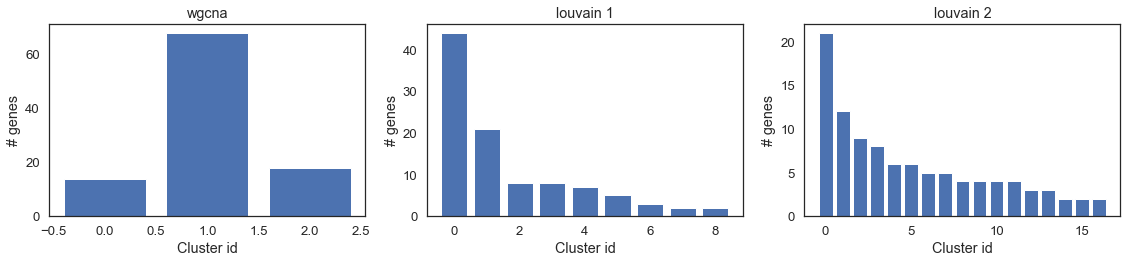

In [166]:
comm_dfs = [top100_wgcna,comm_df1, comm_df2]
comm_names = ['wgcna','louvain 1', 'louvain 2']
plot_gene_cnt_each_cluster(comm_dfs, 'louvain_label', comm_names)

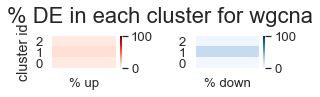

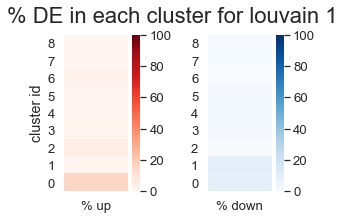

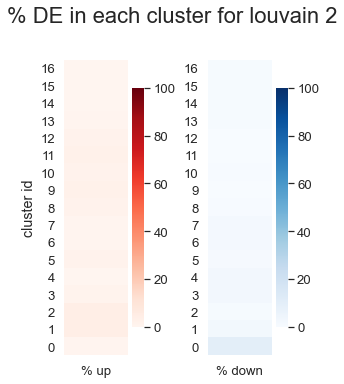

In [167]:
for i, cluster_df in enumerate(comm_dfs):
    cluster_DE_perc(cluster_df, 'louvain_label', comm_names[i], deseq = de_data)

In [182]:
top100_G = nx.convert_matrix.from_pandas_adjacency(top100_tom)

Figure deg_mod=[1],non_deg_mod=[0],num_genes=10,min_weight=0.01 has been saved.


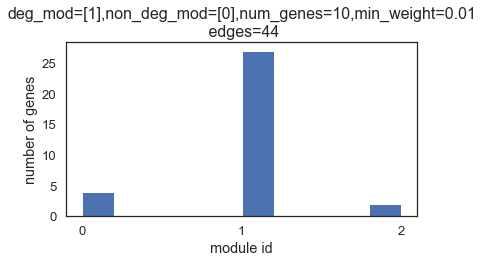

Figure deg_mod=[1],non_deg_mod=[2],num_genes=10,min_weight=0.016 has been saved.


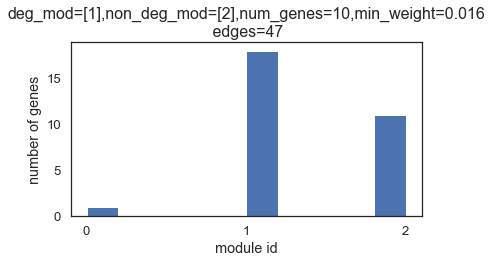

Figure deg_mod=[1],non_deg_mod=[],num_genes=18,min_weight=0.012 has been saved.


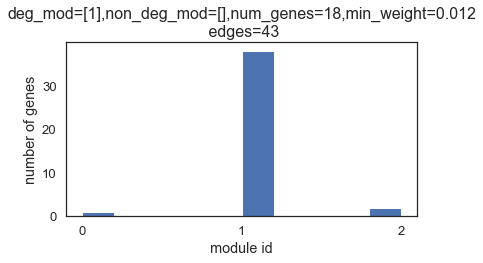

In [212]:
subnetwork_path = r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\subnetworks_Feb11'
G1_n_0, module1_n_0_df, subnetwork_name1 = get_subnetwork([1], 10, 0.01, top100_tom, comm_df = top100_wgcna, deseq = de_data, non_deg_modules = [0], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)
G1_n_2, module1_n_2_df, subnetwork_name2 = get_subnetwork([1], 10, 0.016, top100_tom, comm_df = top100_wgcna, deseq = de_data, non_deg_modules = [2], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)
G1, module1_df, subnetwork_name3 = get_subnetwork([1], 18, 0.012, top100_tom, comm_df = top100_wgcna, deseq = de_data, non_deg_modules = [], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)

In [215]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb11/'
network_to_embed = [top100_G, G1_n_0, G1_n_2, G1]
network_to_embed_names = ['whole network', subnetwork_name1, subnetwork_name2, subnetwork_name3]
emb_list = []
kmeans_list = []
for i, G in enumerate(network_to_embed):
    emb_df = network_embedding(G, 16, 10, 10, embedding_path, subnetwork_names[i])
    emb_list.append(emb_df)
    kmeans_list.append(run_kmeans(emb_df, 3))

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.64it/s]

embedding data saved



Generating walks (CPU: 1):  80%|████████████████████████████████████████████▊           | 8/10 [00:00<00:00, 69.26it/s]

embedding data saved


Generating walks (CPU: 1):  60%|█████████████████████████████████▌                      | 6/10 [00:00<00:00, 52.89it/s]

embedding data saved


Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.74it/s]

embedding data saved
Wall time: 4.16 s


In [226]:
# convert df from adjacency to edgelist
def adj_to_edgelist(adj_df):
    adj_df_copy = adj_df.copy()
    adj_df_copy.values[tuple([np.arange(len(adj_df_copy))]*2)] = np.nan
    edge_df = adj_df_copy.stack().reset_index()
    edge_df['level_0'] = list(map(lambda x:int(x.split('_')[1]), edge_df['level_0']))
    edge_df['level_1'] = list(map(lambda x:int(x.split('_')[1]), edge_df['level_1']))
    return edge_df

In [236]:
subnetwork_names = [subnetwork_name1, subnetwork_name2, subnetwork_name3]
for i, subnet in enumerate([module1_n_0_df, module1_n_2_df, module1_df]):
    edge_df = adj_to_edgelist(subnet)
    edge_df.to_csv(f'C:/Users/bbche/Documents/GitRepos/ohmnet/data/edgelists/{subnetwork_names[i]}.txt', sep = '\t', index = 0, header = None) # subnetwork edge data exported to run on Ohmnet

In [280]:
ohmnet_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\top100\internal_vectors.emb', sep = ' ', skiprows=1, header = None, index_col = 0)
ohmnet_index = list(ohmnet_emb.index)
new_index1 = list(map(lambda x:int(x.split('__')[1]), ohmnet_index))
new_index2 = list(map(lambda x:'ILMN_'+str(x), new_index1))
ohmnet_emb.index = new_index2

# emb_list = [ohmnet_emb]
# emb_names = ['ohmnet embedding']
# for file in os.listdir(embedding_path):
#     emb = pd.read_csv(os.path.join(embedding_path, file), index_col = 0)
#     emb_dfs.append(emb)
#     emb_names.append(file[:-4])
# # switch positions for the first 2: whole and ohmnet embedding
# emb_dfs[0], emb_dfs[1] = emb_dfs[1], emb_dfs[0]
# emb_names[0], emb_names[1] = emb_names[1], emb_names[0]

# Load real subnetwork from the workflow and run it through Ohmnet

In [309]:
subnetwork_path = r'G:\Shared drives\NIAAA_ASSIST\Data\pipeline\mouse\module_subselection_embedding\approach2\YC_Feb4'
subnetwork_dfs = []
subnetwork_names = []
for file in os.listdir(subnetwork_path):
    if file.startswith('deg') and file.endswith('.csv'):
        subnet_df = pd.read_csv(os.path.join(subnetwork_path, file), index_col = 0)
        subnetwork_dfs.append(subnet_df)
        subnetwork_names.append(file.split(',num_gene')[0])

In [310]:
for i, subnet in enumerate(subnetwork_dfs):
    edge_df = adj_to_edgelist(subnet)
    edge_df.to_csv(f'C:/Users/bbche/Documents/GitRepos/ohmnet/data/edgelists/{subnetwork_names[i]}.txt', sep = '\t', index = 0, header = None) # subnetwork edge data exported to run on Ohmnet